In [ ]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import datetime
from keras.applications.vgg19 import VGG19
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from Models import Generator, Discriminator, VGG_LOSS
from DataLoader import DataLoader
from keras.applications.vgg19 import VGG19



gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


channels = 3
lr_height = 128
lr_width = 128
lr_shape = (lr_height, lr_width, channels)

hr_height = lr_height * 4
hr_width = lr_width * 4
hr_shape = (hr_height, hr_width, channels)

optimizer = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

loss = VGG_LOSS(hr_shape)

# Building discriminator

discriminator_model = Discriminator(hr_shape).get_discriminator_model()

discriminator_model.compile(loss="binary_crossentropy", optimizer=optimizer)
#print(discriminator_model.summary())

# Building generator

generator_model = Generator(lr_shape).get_generator_model();
generator_model.compile(loss=loss.vgg_loss, optimizer=optimizer)
#print(generator_model.summary())

# Building combined model


vgg_model = loss.loss_model;

comb_input = Input(shape=lr_shape)
x = generator_model(comb_input)
discriminator_model.trainable=False
comb_val = discriminator_model(x)
features = vgg_model(x)

combined_model = Model(inputs=comb_input, outputs=[comb_val, features])
combined_model.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-3, 1.],
                              optimizer=optimizer)

# Training
epochs = 1500

dataLoader = DataLoader("drive/My Drive/data_train_HR/", 700)

batch_size = 1

#batch_count = int(img_count / batch_size)

batch_count = 35

start_time = datetime.datetime.now()

np.random.seed(10)

log_adversial = open('drive/My Drive/logs/log_adversial.txt', 'w+')
log_content = open('drive/My Drive/logs/log_content.txt', 'w+')

for epoch in range(epochs):

    for r in range(batch_count):

        # Discriminator

        train_images_lr, train_images_hr = dataLoader.get_train_images(batch_size, hr_height, hr_width, 4)
       
        fake_images_hr = generator_model.predict(train_images_lr)

        valid = np.ones(batch_size) - np.random.random_sample(batch_size)*0.1
        fake = np.random.random_sample(batch_size)*0.1
        discriminator_model.trainable = True
        d_loss_real = discriminator_model.train_on_batch(train_images_hr, valid)
        d_loss_fake = discriminator_model.train_on_batch(fake_images_hr, fake)
        #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Generator

        train_images_lr, train_images_hr = dataLoader.get_train_images(batch_size, hr_height, hr_width, 4)

        valid = np.ones(batch_size) - np.random.random_sample(batch_size)*0.1
        discriminator_model.trainable = False
        fake_features = vgg_model.predict(train_images_hr)
        g_loss = combined_model.train_on_batch(train_images_lr, [valid, fake_features])

        log_adversial.write('(%d ; %s)\n' % (epoch*batch_count + r, g_loss[1]))
        log_content.write('(%d ; %s)\n' % (epoch*batch_count + r, g_loss[2]))
        

    elapsed_time = datetime.datetime.now() - start_time
    print("%d time: %s" % (epoch, elapsed_time))

log_adversial.close()
log_content.close()
 
generator_model.save("drive/My Drive/saved_models/generator_m_v2_3.h5")

Tue Dec 22 22:49:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

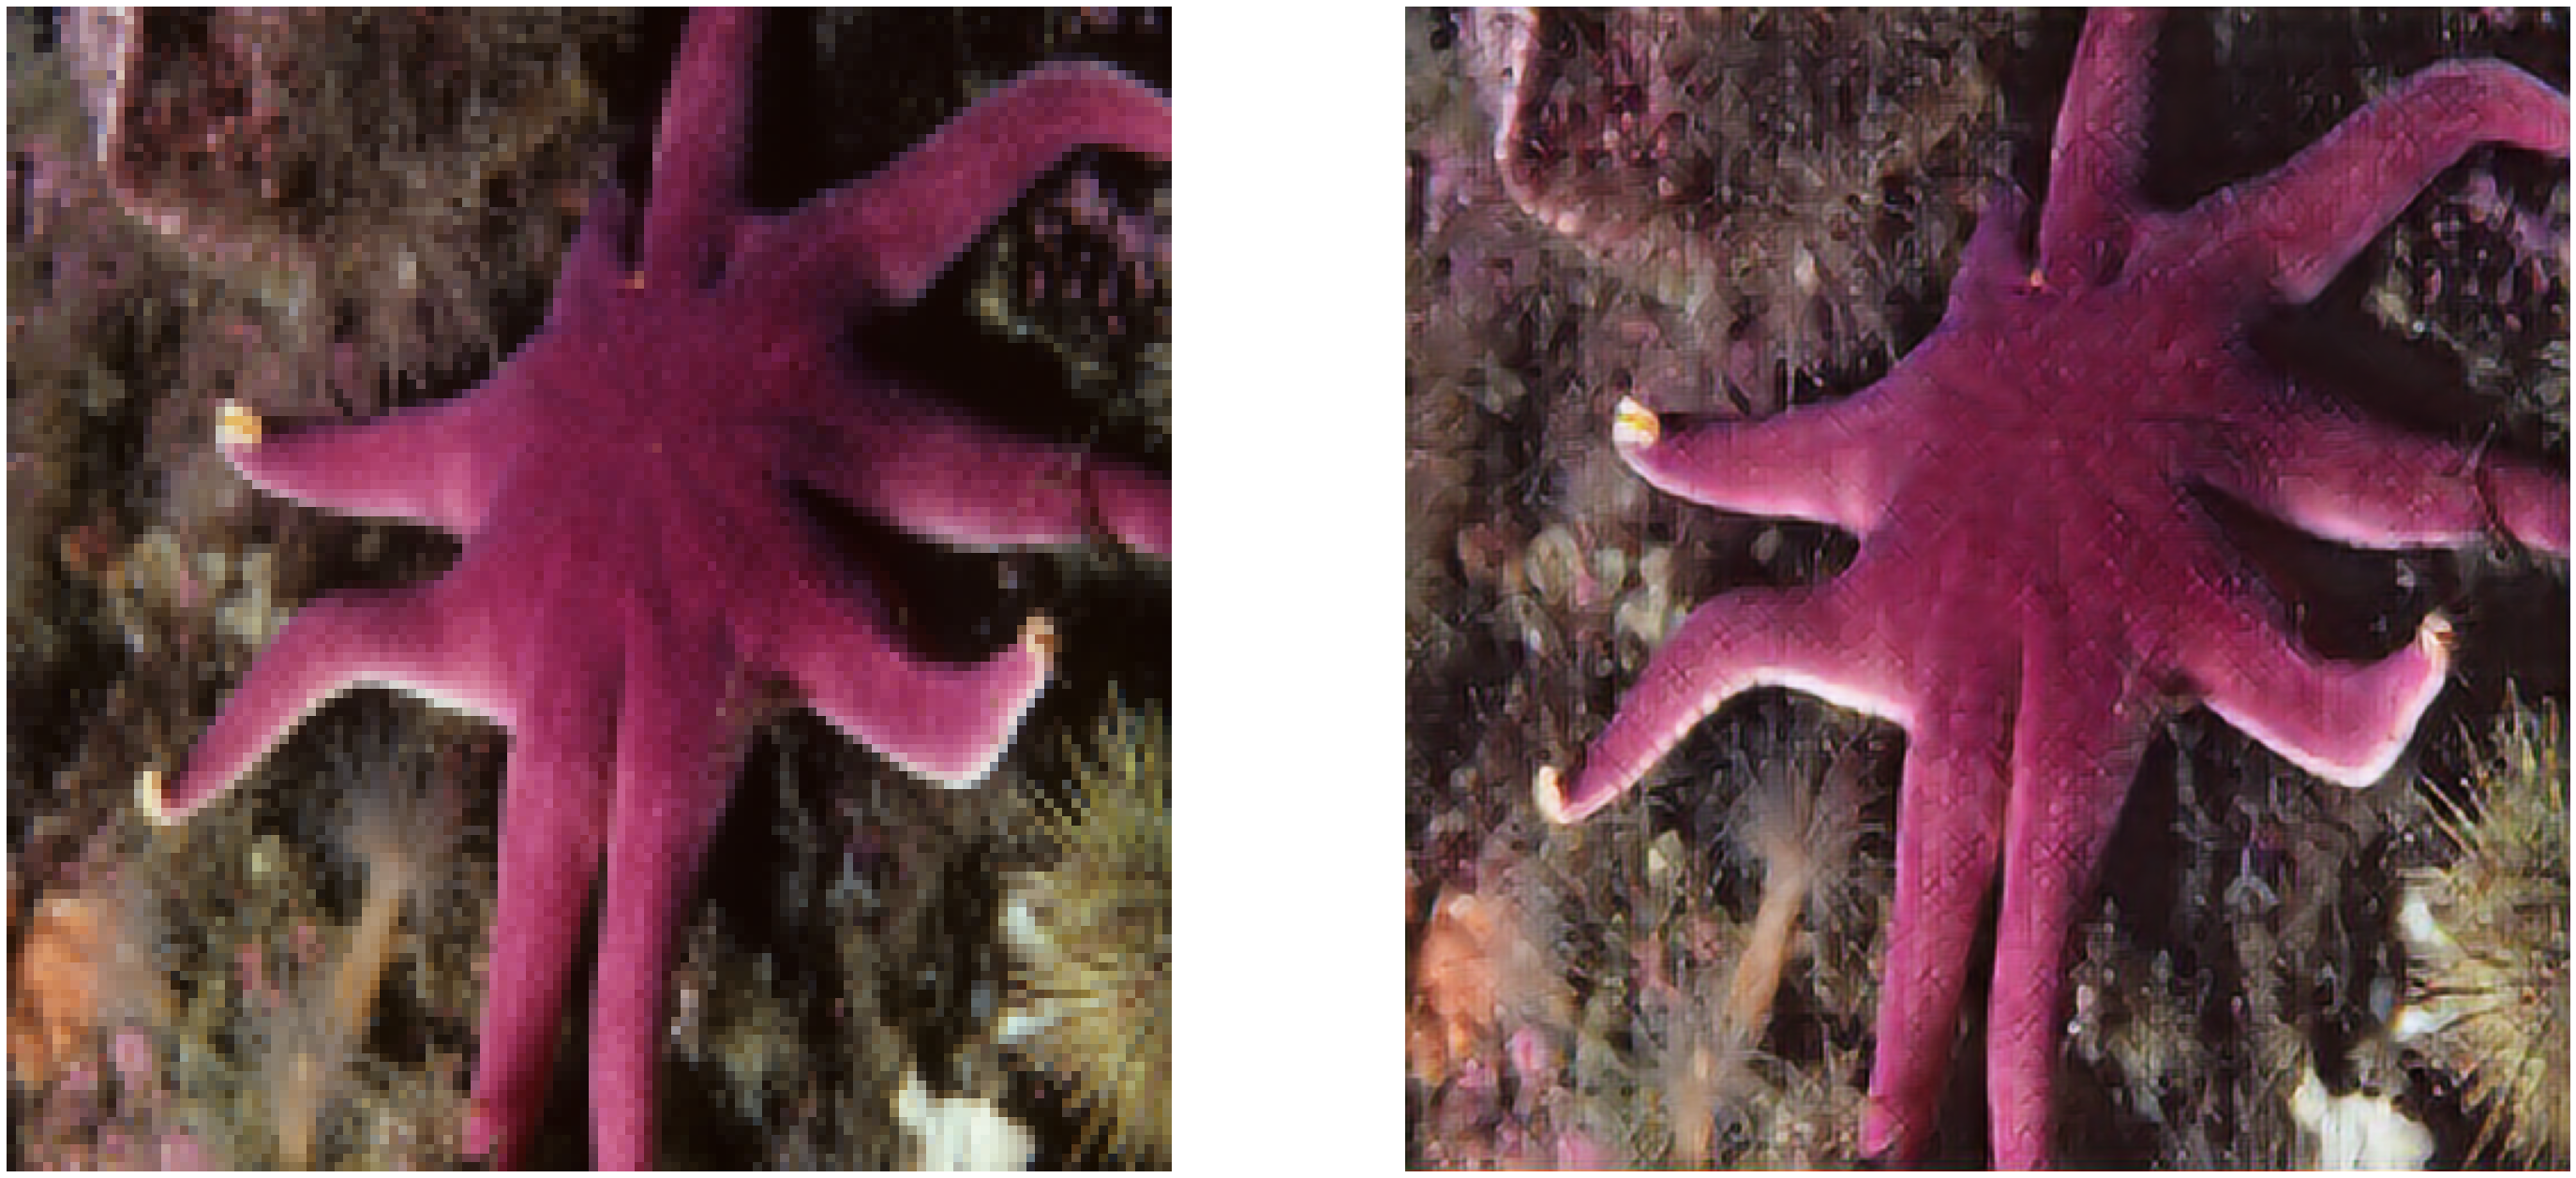

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import imageio
import numpy as np
from skimage import transform
from DataLoader import DataLoader
from numpy import array

gen_model = keras.models.load_model("drive/My Drive/saved_models/generator_m_v2_2.h5", compile=False)


img = imageio.imread("drive/My Drive/data_train_HR/0001.png", pilmode = "RGB")
list_lr = []
low_img = transform.downscale_local_mean(img, (4, 4, 1))
#low_img = img
list_lr.append(low_img)
np_arr = array(list_lr)
np_arr = DataLoader.normalize(np_arr)

pred = gen_model.predict(np_arr)

pred = DataLoader.denormalize(pred)

low_img = low_img.astype(np.uint8)

plt.figure(figsize=(49,49))

plt.subplot(1, 2, 1)
plt.imshow(low_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred[0])
plt.axis("off")

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')